In [2]:
#import required packages

%matplotlib inline
import tensorflow as tf
import gpflow
import numpy as np
from multi_spectralmixture import MultiSpectralMixture as MOSM
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn 
seaborn.set(style="white", color_codes=True)

/home/gabriel/.conda/envs/gpflow1.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


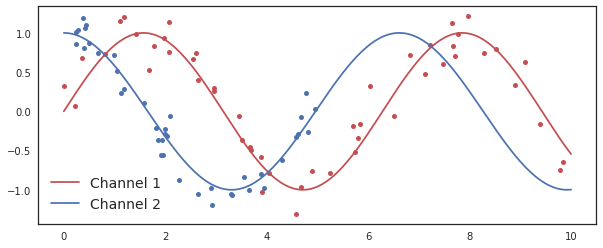

In [3]:
#Generation of input data, feel free to generate/import your own data. 

#latent process
N_sample = 200
X_latent = np.linspace(0, 10, N_sample)
f1 = np.sin(X_latent) 
f2 = np.cos(0.95*X_latent) 

#observations
N1 = 50
N2 = 40
X1_obs = np.random.uniform(0, 10, N1)
X2_obs = np.random.uniform(0, 5, N2)
Y1 = np.sin(X1_obs)  + 0.2*np.random.randn(N1)
Y2 = np.cos(0.95*X2_obs)  + 0.2*np.random.randn(N2)

#plot
fig = plt.figure(figsize=(10,4))
plt.plot(X_latent, f1, 'r-', label='Channel 1')
plt.plot(X1_obs, Y1, 'r.', ms=10)

plt.plot(X_latent, f2, 'b-', label='Channel 2')
plt.plot(X2_obs, Y2, 'b.', ms=10)

plt.legend(loc=3,shadow=True, fancybox=True,prop={'size':14})

By adding an extra input dimension for every observation that represents the source channel, multiple outputs can be modeled within gpflow.

In [4]:
# Format input data
X_input = np.vstack([np.column_stack([np.zeros_like(Y1), X1_obs]), 
                  np.column_stack([np.ones_like(Y2), X2_obs])])
Y_input = np.hstack([Y1, Y2])[:, None]

#augmented input for prediction
X_pred = np.vstack([np.column_stack([np.zeros_like(X_latent), X_latent]), 
                  np.column_stack([np.ones_like(X_latent), X_latent])]) 


#set data dimensions
INPUT_DIM = 1
N_OUTPUTS = 2

#uncomment the following lines to set initial valued for the hyperparameters (not required)

#weights_init = np.ones(N_OUTPUTS)
#means_init = 0.5 * np.ones(N_OUTPUTS)[None, :]
#var_init = np.ones(N_OUTPUTS)[None, :]
#delay_init = np.zeros(N_OUTPUTS)[None, :]
#phase_init = np.zeros(N_OUTPUTS)

#kern = MOSM(1, N_OUTPUTS, weights_init, 
#            means_init, var_init, 
#            delay_init, phase_init)


#Set the number of components
number_of_components = 2
kern = MOSM(INPUT_DIM, N_OUTPUTS)
for i in range(number_of_components-1):
        kern += MOSM(INPUT_DIM, N_OUTPUTS)
        
#instantiate model
model = gpflow.models.GPR(X_input, Y_input, kern)
model.likelihood.variance = 0.5

Training the model, feel free to use any other optimizer

In [5]:
gpflow.train.ScipyOptimizer().minimize(model, disp=True, maxiter=500)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: -15.821079
  Number of iterations: 501
  Number of functions evaluations: 617


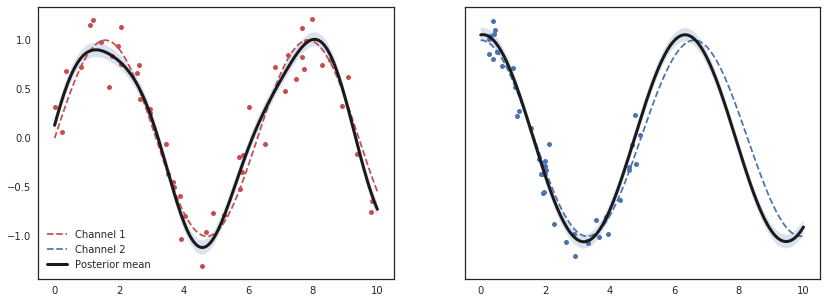

In [6]:
#predict at inputs given by X_pred
Y_pred, STD_pred = model.predict_y(X_pred)  

fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)
ch1, = axes[0].plot(X_latent, f1, 'r--', label='Channel 1')
axes[0].plot(X1_obs, Y1, 'r.', ms=10)
pred, = axes[0].plot(X_latent, Y_pred[:N_sample], 'k-', lw=3, label='Posterior mean')
axes[0].fill_between(X_latent, (Y_pred[:N_sample]-2*STD_pred[:N_sample]).reshape([-1]), 
                     (Y_pred[:N_sample]+2*STD_pred[:N_sample]).reshape([-1]), alpha=0.2) 

ch2, = axes[1].plot(X_latent, f2, 'b--', label='Channel 2')
axes[1].plot(X2_obs, Y2, 'b.', ms=10)
axes[1].plot(X_latent, Y_pred[N_sample:], 'k-', lw=3)
axes[1].fill_between(X_latent, (Y_pred[N_sample:]-2*STD_pred[N_sample:]).reshape([-1]), 
                     (Y_pred[N_sample:]+2*STD_pred[N_sample:]).reshape([-1]), alpha=0.2) 

axes[0].legend(handles=[ch1, ch2, pred], loc=3,shadow=True, fancybox=True,prop={'size':10})

Print model parameters

In [7]:
print(model)

<Parameter name:GPR/kern/multispectralmixture_1/constant [trainable] shape:(2,) transform:(none) prior:None>
value: [-1.35642105, -0.10209069]

<Parameter name:GPR/kern/multispectralmixture_1/mean [trainable] shape:(1, 2) transform:(none) prior:None>
value: [[-2.2929902 ,  6.16944001]]

<Parameter name:GPR/kern/multispectralmixture_1/variance [trainable] shape:(1, 2) transform:+ve prior:None>
value: [[  4.43364984e-06,   1.00000037e-06]]

<Parameter name:GPR/kern/multispectralmixture_1/delay [trainable] shape:(1, 2) transform:PartiallyFixed prior:None>
value: [[ 0.       , -9.7757292]]

<Parameter name:GPR/kern/multispectralmixture_1/phase [trainable] shape:(2,) transform:PartiallyFixed prior:None>
value: [  0.       ,  16.9605291]

<Parameter name:GPR/kern/multispectralmixture_2/constant [trainable] shape:(2,) transform:(none) prior:None>
value: [-8.25667888, -8.75823595]

<Parameter name:GPR/kern/multispectralmixture_2/mean [trainable] shape:(1, 2) transform:(none) prior:None>
value: